## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [ ]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env1 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [ ]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [ ]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    valid_Actions = []
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [ ]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [ ]:
def epsilon_greedy(state, time):
    max_epsilon = 1.0
    min_epsilon = 0.001
    epsilon = (min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time))
    thresholdValue = np.random.random()

    if (thresholdValue) < epsilon:
        action = random.choice(valid_actions(state)) #Exploration: randomly choosing and action
    else:
        state = Q_state(state)
        action = max(Q_dict[state],key=Q_dict[state].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [ ]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [ ]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [(('x-x-5-x-8-x-x-x-x'),(0,7)),(('3-x-x-6-x-x-x-x-x'),(5,7)),(('x-x-7-x-x-x-x-8-x'),(3,1)),(('x-2-x-x-x-x-7-x-x'),(3,3))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode      

In [ ]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [ ]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [ ]:
# Defining the hyperparameters
EPISODES = 5000000
LR = 0.3                    #learning rate
GAMMA = 0.9

threshold = 2000            #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 30000    #every these many episodes, the Q-dict will be updated

### Q-update loop ---write your code here

In [12]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe()
    curr_state = env.state
        
    add_to_dict(curr_state)
    game_status = False
          
    while not game_status: # Play the game till it is not terminal
        
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, game_status = env.step(curr_state, curr_action) 
        add_to_dict(next_state)
        
        # UPDATE RULE
        if not game_status: # If the game_status = Resume
            # max_next gets the action corresponding to max q-value of next state
            max_next = max(Q_dict[Q_state(next_state)],key=Q_dict[Q_state(next_state)].get)
            Q_dict[Q_state(curr_state)][curr_action] += LR * ((reward + (GAMMA*(Q_dict[Q_state(next_state)][max_next]))) - Q_dict[Q_state(curr_state)][curr_action] ) 
        
        else: # When terminal state is encountered 
            # For the final state either Win or Tie, there won't be any next state. Therefore, GAMMA*0 makes the whole part equal to 0. Hence, removed.
            Q_dict[Q_state(curr_state)][curr_action] += LR * ((reward - Q_dict[Q_state(curr_state)][curr_action]))

        curr_state = next_state       #state(t) became state(t-1)
           
    #TRACKING Q-VALUES
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')
           
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

print('Elapsed_time: ', elapsed_time)

Elapsed_time:  5789.5334305763245


#### Check the Q-dictionary

In [13]:
len(Q_dict)

1763665

In [14]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
max(Q_dict['6-x-3-x-x-1-x-x-8'], key=Q_dict['6-x-3-x-x-1-x-x-8'].get)

(1, 9)

In [29]:
max(Q_dict['5-x-6-7-4-x-x-x-x'], key=Q_dict['5-x-6-7-4-x-x-x-x'].get)

(6, 3)

In [30]:
max(Q_dict['x-6-3-2-x-x-5-x-x'], key=Q_dict['x-6-3-2-x-x-5-x-x'].get)

(4, 7)

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [ ]:
# Write the code for plotting the graphs for state-action pairs tracked
with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)

In [16]:
for key, value in States_track.items():
    for k,v in value.items():
        print(len(v))

2500
2500
2500
2499


In [17]:
for key, value in States_track.items():
    for k,v in value.items():
        print(key, k)

x-x-5-x-8-x-x-x-x (0, 7)
3-x-x-6-x-x-x-x-x (5, 7)
x-x-7-x-x-x-x-8-x (3, 1)
x-2-x-x-x-x-7-x-x (3, 3)


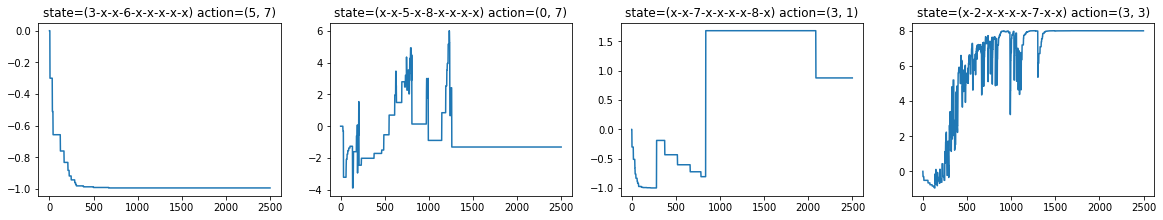

In [19]:
# Graph to check the Q-value convergence for the States_track
xaxis = np.asarray(range(0, len(States_track['x-x-5-x-8-x-x-x-x'][(0, 7)])))

plt.figure(0, figsize=(20,7))
plt.subplot(241)
plt.title('state=(3-x-x-6-x-x-x-x-x) action=(5, 7)')
plt.plot(xaxis,np.asarray(States_track['3-x-x-6-x-x-x-x-x'][(5, 7)]))

plt.subplot(242)
plt.title('state=(x-x-5-x-8-x-x-x-x) action=(0, 7)')
plt.plot(xaxis,np.asarray(States_track['x-x-5-x-8-x-x-x-x'][(0, 7)]))

plt.subplot(243)
plt.title('state=(x-x-7-x-x-x-x-8-x) action=(3, 1)')
plt.plot(xaxis ,np.asarray(States_track['x-x-7-x-x-x-x-8-x'][(3, 1)]))

plt.subplot(244)
plt.title('state=(x-2-x-x-x-x-7-x-x) action=(3, 3)')
plt.plot(np.asarray(range(0, 2499)),np.asarray(States_track['x-2-x-x-x-x-7-x-x'][(3, 3)]))

plt.show()

### Epsilon - decay check

In [ ]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

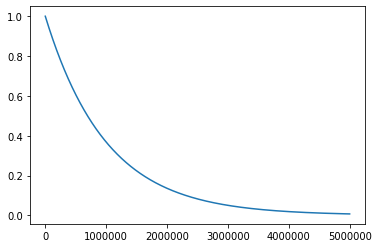

In [ ]:
plt.plot(time, epsilon)
plt.show()